## Susannah D'Arcy Assignment 2
# Analysis of Tech Stocks 
### Stocks Used: INTC, SNE, NTDOY,  MSFT

My goal for this notebook is to gather and compare stocks which represent the game industry. To do this I will analyse Nintendo, Sony, Microsoft to represent console gaming, and then Intel for the PC gaming industry. My comparing these stocks I hope to see the rise and falls of the gaming industry, and possibly the victory of the 'console wars'. However Microsoft stock would be effected by both Window and Xbox sales, therefore Microsoft stock values will be skewed. Although this means we could also use Microsoft as an example of the PC industry.

## Gathering Data
To gather the stock information I will be using url library to access the website, and then Beautiful Soup (bs4) which will allow me to easily parse the wanted elements of the HTML file.

In [3]:
import urllib.request
import bs4
from datetime import datetime
import pandas as pd
import numpy as np

bs4 generates a parser which I can use to select elements based on the html tag, in this case, tr and td. As all the data are within table hmtl elements.

In [189]:
#Function to gather html data from a specific link
def getStockData(link):
    #Request the link, and collect its data
    response = urllib.request.urlopen(link)
    html = response.read().decode()
    table = []
    #Generate parser to read and search through reponse
    parser = bs4.BeautifulSoup(html,"html.parser")
    #Collecting data: Find all rows (tr) and within the row their cells (td)
    for match in parser.find_all("tr"): 
        rowElements = []
        for column in match.find_all("td"):
            text = column.get_text()
            #Intel html file separates months with -, we do not want to store this
            if text != '—':
                #Turns all string Nan text into a NaN which python and pandas recognises.
                if text == 'NaN':
                    text = np.nan
                rowElements.append(text)
        # We don't want to add empty lists (rows which were originally -'s) and the Header rows, which the first column will either be Stock or Stock\xa0 depending on the stock
        if  len(rowElements) > 0 and not(rowElements[0] == 'Stock' or rowElements[0] == 'Stock\xa0') :
            #Intel has a different column order for the dates
            if rowElements[0] == "INTC":
                #Convert 3 cells into 1 String to parse into datetime
                d = rowElements[1] + ' ' + rowElements[2] + ' ' + rowElements[3]
                #Converts our string into a date time object
                date = datetime.strptime(d,  '%d %B %Y').date()
            else:
                d = rowElements[1] + ' ' + rowElements[2] + ' ' + rowElements[3]
                date = datetime.strptime(d,  '%Y %m %d').date()
            row = [date, rowElements[0], float(rowElements[4]), float(rowElements[5]), float(rowElements[6]), float(rowElements[7])]  
            #Dictionary representation of our table                     
            table.append(row)
    #Convert the dictionary into a pandas data frame
    df = pd.DataFrame(table, columns =['Date', 'Stock', 'Open', 'High', 'Low', 'Close'])
    df = df.set_index(pd.DatetimeIndex(df['Date']))
    df = df.drop(columns='Date')
    # return generated df which contains the stock information
    return df

In [190]:
IntelLink = "http://mlg.ucd.ie/modules/COMP30760/stocks/intc.html"
IntelDf = getStockData(IntelLink)
IntelDf.to_csv('IntelStock.csv', sep=';')

SonyLink = "http://mlg.ucd.ie/modules/COMP30760/stocks/sne.html"
SonyDf =  getStockData(SonyLink)
SonyDf.to_csv('SonyStock.csv', sep=';')

NintendoLink = "http://mlg.ucd.ie/modules/COMP30760/stocks/ntdoy.html"
NintendoDf = getStockData(NintendoLink)
NintendoDf.to_csv('NintendoStock.csv', sep=';')

MicrosoftLink = "http://mlg.ucd.ie/modules/COMP30760/stocks/msft.html"
MicrosoftDf = getStockData(MicrosoftLink)
MicrosoftDf.to_csv('MicrosoftStock.csv', sep=';')

### Recorded Data

In [191]:
print(IntelDf.head())
print(SonyDf.head())
print(NintendoDf.head())
print(MicrosoftDf.head())

           Stock       Open       High        Low      Close
Date                                                        
2012-01-03  INTC  24.620001  24.889999  24.389999  24.540001
2012-01-04  INTC        NaN        NaN        NaN        NaN
2012-01-05  INTC  25.059999  25.450001  24.980000  25.400000
2012-01-06  INTC  25.209999  25.400000  25.010000  25.250000
2012-01-09  INTC  25.400000  25.559999  25.219999  25.469999
           Stock       Open   High        Low      Close
Date                                                    
2012-01-03   SNE  18.280001  18.50  18.280001  18.379999
2012-01-04   SNE  18.240000  18.27  18.139999  18.219999
2012-01-05   SNE  17.830000  17.85  17.600000  17.700001
2012-01-06   SNE  17.570000  17.57  17.370001  17.440001
2012-01-09   SNE  17.510000  17.51  17.350000  17.469999
            Stock       Open       High        Low      Close
Date                                                         
2012-01-03  NTDOY  17.230000  17.600000  17.230000

## Remove NaN Values
To remove NaN values I decided to replace each NaN with the average of the value before and after it. I used the interpolate function which takes the difference between the first previous non-NaN value and the following non-NaN, it will then distribute the difference linearly depending on the number of NaN in sequence. I.e if we had (2, NaN, 4) this will interpolate into (2, 3, 4). If we had (2, NaN, NaN, 5) it will return (2, 3, 4, 5). This means we will get an even distribution of the difference of stock values for the missing dates. I feel this will represent the missing values better than simple replacing all NaN with the previous non-NaN, as this will just duplicate stock prices. We cannot use the overall average as our data spans a long time frame, and the average does not represent the stock on a particular day.


In [194]:
#Replace NaN values with the linear interpolate, which will average the value before and after NaN value. 
IntelDfClean =IntelDf.interpolate(method ='linear', limit_direction ='forward', axis = 0)
SonyDfClean = SonyDf.interpolate(method ='linear', limit_direction ='forward', axis = 0)
NintendoDfClean = NintendoDf.interpolate(method ='linear', limit_direction ='forward', axis = 0)
MicrosoftDfClean = MicrosoftDf.interpolate(method ='linear', limit_direction ='forward', axis = 0)

#Write Clean dataframe to csv
IntelDfClean.to_csv('IntelClean.csv', sep=';')
SonyDfClean.to_csv('SonyClean.csv', sep=';')
NintendoDfClean.to_csv('NintendoClean.csv', sep=';')
MicrosoftDfClean.to_csv('MicrosoftClean.csv', sep=';')

In [195]:
print("Before")
print(IntelDf.isnull().sum())
print("After")
print(IntelDfClean.isnull().sum())

Before
Stock      0
Open     121
High     121
Low      121
Close    121
dtype: int64
After
Stock    0
Open     0
High     0
Low      0
Close    0
dtype: int64


Here we see that we have remove all NaN values from our data set. However to see if my replacement method has affected my data set I will compare the statistical summary of the before and after NaN replacement.

In [196]:
#Statistical  Summary of the data sets before and after replacing NaNs
print("Before")
print(IntelDf.describe())
print("After")
print(IntelDfClean.describe())

#The difference between raw and clean data sets
difference = IntelDfClean.describe() - IntelDf.describe()
#Percentage change difference
differencePercentage = ((IntelDfClean.describe() - IntelDf.describe())/(IntelDfClean.describe() + IntelDf.describe())) * 100
print("Change in Values")
print(difference)
print("Percentage Change in Values")
print(differencePercentage)

Before
              Open         High          Low        Close
count  1850.000000  1850.000000  1850.000000  1850.000000
mean     34.809562    35.142719    34.482924    34.826973
std       9.763577     9.883751     9.635572     9.765896
min      19.520000    19.549999    19.230000    19.360001
25%      26.510000    26.740000    26.340000    26.540001
50%      33.785000    34.150002    33.509998    33.885000
75%      43.547499    44.527499    43.107500    43.585000
max      58.889999    59.590000    58.500000    58.820000
After
              Open         High          Low        Close
count  1971.000000  1971.000000  1971.000000  1971.000000
mean     34.772499    35.105112    34.447831    34.790241
std       9.766891     9.888405     9.639865     9.771174
min      19.520000    19.549999    19.230000    19.360001
25%      26.497499    26.735000    26.299999    26.495000
50%      33.770000    34.130001    33.490002    33.869999
75%      43.485000    44.405001    43.049999    43.455000
m

From this we can see that the interpolate linear method hasn't change our data set, as we have a minimum percentage change in our statistical summary of our data set, with the highest being our 75% range which had an decrease of 0.15%.

## Analysis of Stock Individually

To analyse each stock individually I will first create new data frames for monthly, quarterly and annual frequencies. From these I will be able to see the Stock prices change over time, and any outlying observations for each time series.

In [197]:
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline 

### Intel

#### Daily Frequencies
Our data set is currently in a daily frequency. From this we can create these graphs

           Stock       Open       High        Low      Close
Date                                                        
2012-01-03  INTC  24.620001  24.889999  24.389999  24.540001
2012-01-04  INTC  24.840000  25.170000  24.684999  24.970000
2012-01-05  INTC  25.059999  25.450001  24.980000  25.400000
2012-01-06  INTC  25.209999  25.400000  25.010000  25.250000
2012-01-09  INTC  25.400000  25.559999  25.219999  25.469999
count    1971.000000
mean       34.790241
std         9.771174
min        19.360001
25%        26.495000
50%        33.869999
75%        43.455000
max        58.820000
Name: Close, dtype: float64


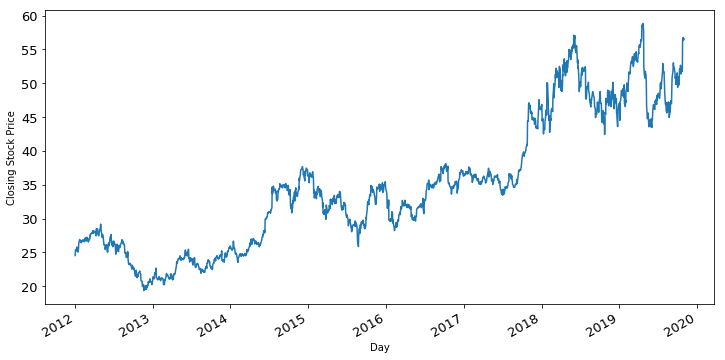

In [198]:
print(IntelDfClean.head())
print(IntelDfClean['Close'].describe())
p = IntelDfClean['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Day");

From this graph we see that the stock of Intel is not very consistent as we have a very bumpy line, as the stock values frequently decrease and increase. However we can see that there is an overall increased growth of the stock with time. From the statistical summary we see that the average value of the Intel is 34.79. The lowest price is 19.36, and the max has been 58.82.

In [199]:
print(IntelDfClean.loc[IntelDfClean['Close'] == 19.360001])
print(IntelDfClean.loc[IntelDfClean['Close'] == 58.820000])

           Stock   Open       High    Low      Close
Date                                                
2012-11-21  INTC  19.52  19.549999  19.23  19.360001
           Stock       Open       High        Low  Close
Date                                                    
2019-04-22  INTC  58.150002  58.830002  57.880001  58.82


Intel was at its lowest during the start of our data set, with the highest stock value being recently. This also shows that the stock price has greatly increased over the years, and Intel is at its current high.

#### Monthly Frequencies
To convert my daily data set to a monthly frequency I will make use datetime and resample our data set by Month (M)

                 Open       High        Low      Close
Date                                                  
2012-01-31  25.826500  26.062500  25.598750  25.872250
2012-02-29  26.771000  26.978500  26.558500  26.784750
2012-03-31  27.446364  27.648182  27.285909  27.485455
2012-04-30  27.925000  28.194500  27.768250  28.004750
2012-05-31  26.950682  27.164318  26.643864  26.898636
count    94.000000
mean     34.764725
std       9.767734
min      20.452857
25%      26.419286
50%      33.779474
75%      43.891557
max      55.832619
Name: Close, dtype: float64


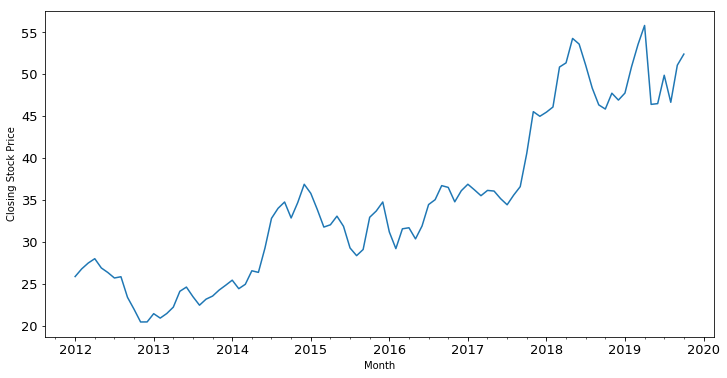

In [200]:
#Resampling
intel_monthly = IntelDfClean.resample("M").mean()
print(intel_monthly.head())
print(intel_monthly['Close'].describe())
p = intel_monthly['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Month");

Resampling our dataset by month has smoothed our graph, which makes it much easier to see the peaks and drops in the Intel stock price. From comparing the describe function output, we can see that our values have changed slightly. From this we can also see the worse and best month for Intel’s stock price. 

Our original method for finding the worse and best day does not work for our resampled dataset, which means I will need to directly find the min/max value in our comparison section of .loc. This will be done with the min function, which returns the minimum value for Close column

In [201]:
print(intel_monthly.loc[intel_monthly['Close'] == min(intel_monthly['Close'])])
print(intel_monthly.loc[intel_monthly['Close'] == max(intel_monthly['Close'])])

                 Open      High        Low      Close
Date                                                 
2012-11-30  20.524286  20.73381  20.286666  20.452857
                 Open       High        Low      Close
Date                                                  
2019-04-30  55.860714  56.247144  55.378809  55.832619


Intel worse month was November 2012, and best month was April 2019.
From the graph we can see that in 2019 we has the highest stock price, and then a big drop. Lets look into this further. With splicing the graph into 2019 time frame.

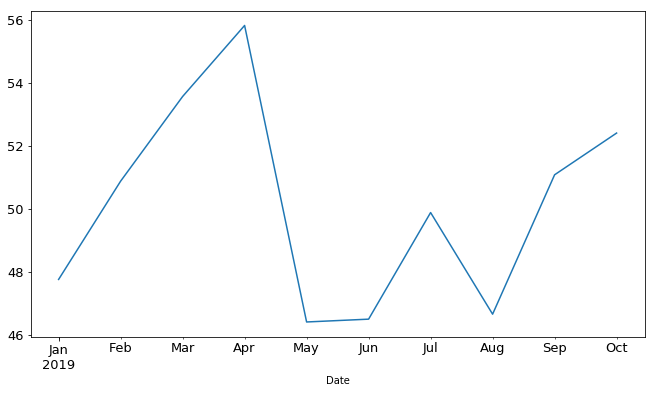

In [202]:
p = intel_monthly['Close']["2019-1":"2019-12"].plot(figsize=(11, 6), fontsize=13)

According to NBC the Intel stock was at an all-time high due to the increase of Chip market stocks ETF (Stevens 2019). "From January to April, the ETF surged more than 40%, ultimately hitting an all-time high on April 24"(Stevens 2019). However due to China tariff and trade wars, their stock price fell. This would have affected Intel Stock price as they rely chip manufacturing. The article also states that Intel stock price drop could also be due to the rise of its competitor AMD, which is taking away its market share (Stevens 2019).

#### Quarterly Frequencies
To resample our data into a quarterly frequency I will again use resample, but with this time Q

                 Open       High        Low      Close
Date                                                  
2012-03-31  26.705968  26.920645  26.507016  26.739032
2012-06-30  27.079365  27.324762  26.815794  27.068095
2012-09-30  25.108413  25.329286  24.842222  25.060159
2012-12-31  20.992903  21.197661  20.789839  20.969274
2013-03-31  21.277417  21.439833  21.108583  21.281917
count    32.000000
mean     35.128988
std       9.994508
min      20.969274
25%      26.985830
50%      33.826992
75%      44.432163
max      53.107109
Name: Close, dtype: float64


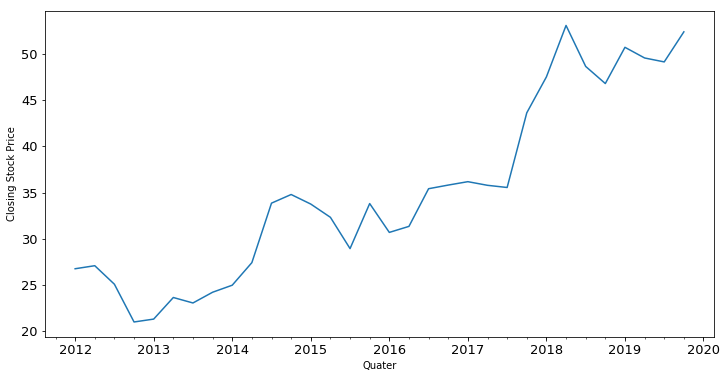

In [40]:
#Resampling
intel_quarterly = IntelDfClean.resample("Q").mean()
print(intel_quarterly.head())
print(intel_quarterly['Close'].describe())
p = intel_quarterly['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Quater");

In [58]:
print('Worse Quarter')
print(intel_monthly.loc[intel_monthly['Close'] == min(intel_monthly['Close'])])
print('Best Quarter')
print(intel_monthly.loc[intel_monthly['Close'] == max(intel_monthly['Close'])])

                 Open      High        Low      Close
Date                                                 
2012-11-30  20.524286  20.73381  20.286666  20.452857
                 Open       High        Low      Close
Date                                                  
2019-04-30  55.860714  56.247144  55.378809  55.832619


Similarly, to the previous graphs we can see the consistent rise of Intel’s stock, with some drops. The best quarter for Intel was First Quarter of 2019, and the worst was Last quarter of 2012. This shows that the worse day, month and quarter are all related. This however might change as we increase to a larger frequency. 

#### Yearly Frequencies

                 Open       High        Low      Close
Date                                                  
2012-12-31  24.980640  25.202160  24.747440  24.967980
2013-12-31  23.045298  23.239841  22.865119  23.058790
2014-12-31  30.286369  30.552401  30.044286  30.321706
2015-12-31  32.150595  32.499683  31.842698  32.178353
2016-12-31  33.303056  33.569980  33.031310  33.328552
Worse Year
                 Open       High        Low     Close
Date                                                 
2013-12-31  23.045298  23.239841  22.865119  23.05879
Best Year
                 Open       High        Low      Close
Date                                                  
2019-12-31  50.046137  50.557014  49.580924  50.097488


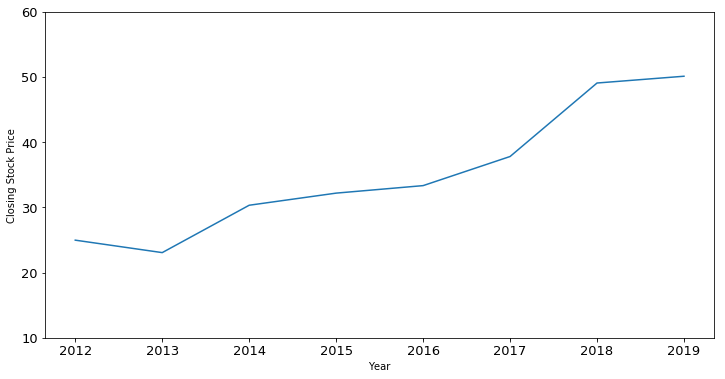

In [62]:
#Resampling
intel_yearly = IntelDfClean.resample("Y").mean()
print(intel_yearly.head())
p = intel_yearly['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.ylim([10,60])
plt.xlabel("Year");
print('Worse Year')
print(intel_yearly.loc[intel_yearly['Close'] == min(intel_yearly['Close'])])
print('Best Year')
print(intel_yearly.loc[intel_yearly['Close'] == max(intel_yearly['Close'])])

With our increased resampling our graph has been extremely smoothed. While this does show the consistent rise of Intel, whoever we lose the very important details and information we can gather from seeing the drops and rises within the graph. If you were to sole look at this Year Graph we would think that Intel stocks are consistent. However, when we analyse the Quarter Graph we can see that Intel has had a great drop recently, which means you might be less likely to purchase a stock.

While our out best date hasn’t changed from year to quarter, to month to day. Our worse year has, this could suggest that the big drop in the November 2012 had a big effect of the stock values, which resulting in the following year having an overall worse stock value.

### Sony
I will know look into the Sony stock by analysing the monthly, quarterly and annual frequencies. However as I have already done previously an in-depth analysis for Intel, to avoid repeating myself, for Sony and the next stocks I will generate each frequency and point out any important information, and further look into interesting time frames.

#### Daily Frequencies

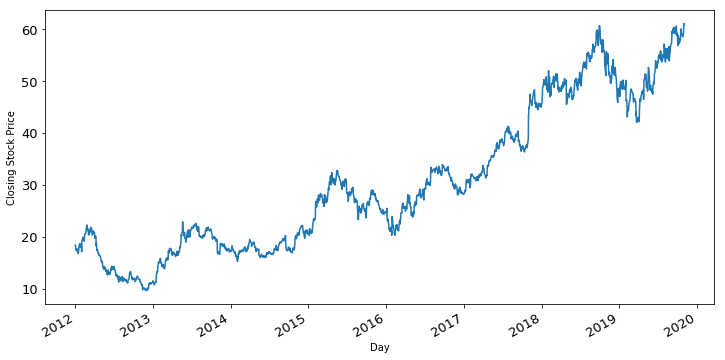

In [203]:
p = SonyDfClean['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Day");

#### Monthly Frequencies

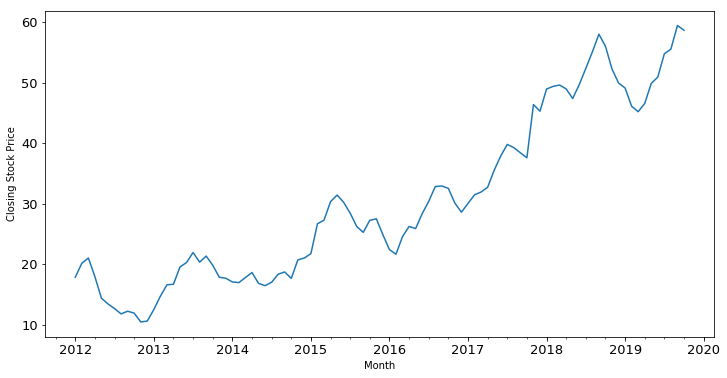

In [73]:
#Resampling
sony_monthly = SonyDfClean.resample("M").mean()
p = sony_monthly['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Month");

#### Quarterly Frequencies

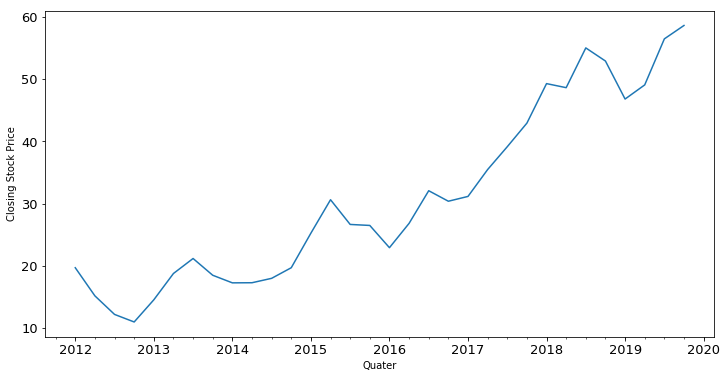

In [74]:
#Resampling
sony_quarterly = SonyDfClean.resample("Q").mean()
p = sony_quarterly['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Quater");

From the daily, monthly and quarterly graphs we can see a big drop recently in Sony’s stocks. Let’s investigate this further.

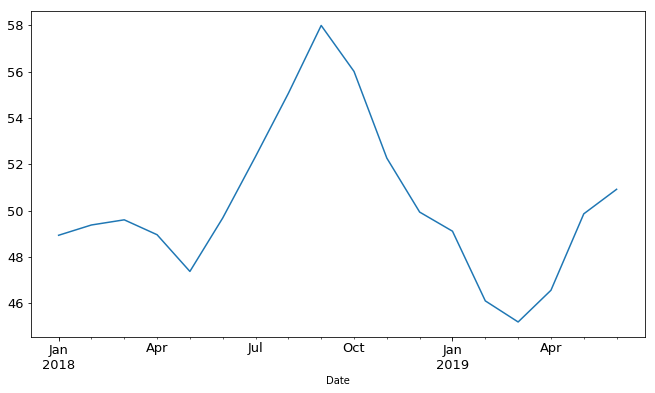

In [77]:
p = sony_monthly['Close']["2018-1":"2019-6"].plot(figsize=(11, 6), fontsize=13)

In 2018 we saw a big rise in Sony's stock, according to The Motley Fool, this is due to the huge success of Sony's PlayStation exclusive titles God of War and Spider-Man (Noonan 2018). Sony have also has success in their film division, with great box office hits of Venom, Jumanji and Hotel Transylvania 3 (Noonan 2018). This shows that while Sony as a company is purely based on console gaming the success of their PlayStation and its games can greatly affect the Sony stock.

However just after this peak we see a greater fall, Nasdaq suggest that this could be due to the fact that Sony has a disappointing quarter in February, and that Google had announce its plans for launching its own cloud gaming system Stadia (Noonan 2018). Cloud gaming services is the currently predicted to be the future of gaming, therefore companies such as Sony who rely on hardware gaming systems it can propose a great threat to the company. As Sony's game and network segment generates 30% of the company’s income (Noonan 2018). Sony now does have a gaming streaming service, PlayStation Now. Therefore, to possibly combat this competition they will need to focus on their cloud streaming service.

#### Yearly Frequencies

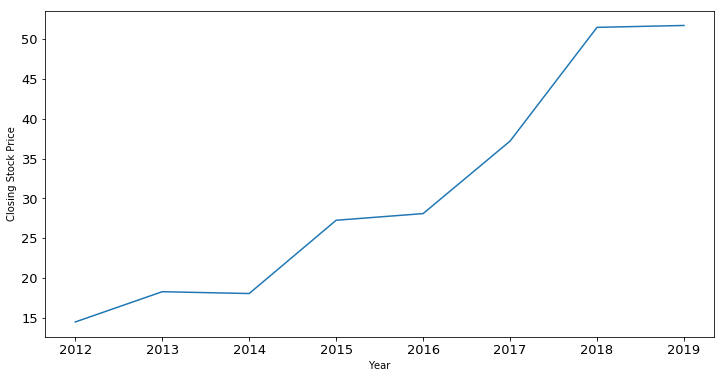

In [75]:
#Resampling
sony_yearly = SonyDfClean.resample("Y").mean()
p = sony_yearly['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Year");

Even though Sony had a big dip in their stock price, from this graph it seems that they were able to recover and plateau from 2018 to 2019, which means that there stock has returned to its original price before the drop. However there does not seem to be any improvement in the cost of Sony, which is why see a flat line in our graph.

### Nintendo

#### Daily Frequencies

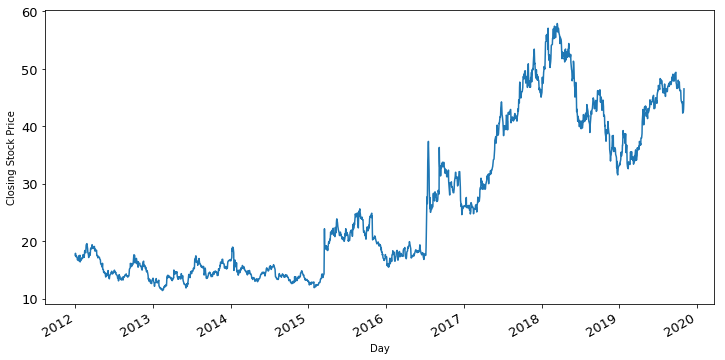

In [82]:
p = NintendoDfClean['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Day");

#### Monthly Frequencies

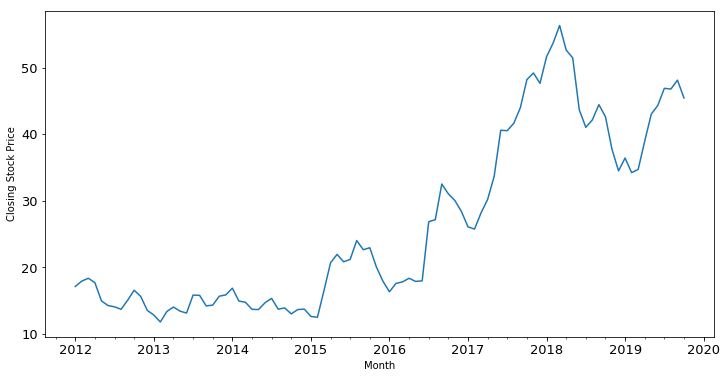

In [83]:
#Resampling
nintendo_monthly = NintendoDfClean.resample("M").mean()
p = nintendo_monthly['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Month");

#### Quarterly Frequencies

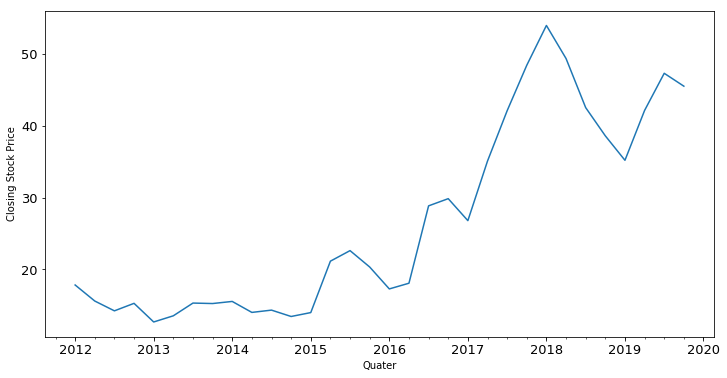

In [84]:
#Resampling
nintendo_quarterly = NintendoDfClean.resample("Q").mean()
p = nintendo_quarterly['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Quater");

We see a big jump in the stock price starting in 2017, this is due to the great success of the Nintendo Switch, which was released in March 3, 2017. However, after a year we see a large drop. Let’s explore this further.

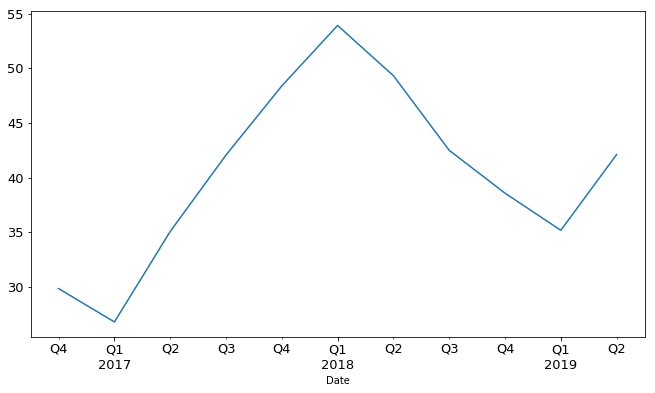

In [93]:
p = nintendo_quarterly['Close']["2016-12":"2019-6"].plot(figsize=(11, 6), fontsize=13)

From The Motley Fool, they state that Nintendo had a 10 year high due to the sales for the Switch, and from the release of more mobile games (Noonan 2018). The stock had a steep drop of approximately 20% in June 2018 (Noonan 2018). Noonan isn't sure what the true cause for this drop is, however, he suggests that it could be due to the disappointed E3 (Electronic Entertainment Expo) showing, also due to Nintendo Switch having an online gaming platform (Noonan 2018). This show the importance of E3 as it can affect the stock prices of the tech industry. Which is why later I will evaluate if the E3 has affected our stock prices, and from them see who 'won E3'.

As seen from Sony, these companies lack of online services has shown to affect their stock values, as they are not preparing for the future. However Nintendo does now have an online gaming service and is improving it, which is why possibly we see the stock value increase again after the first quarter of 2019

#### Yearly Frequencies

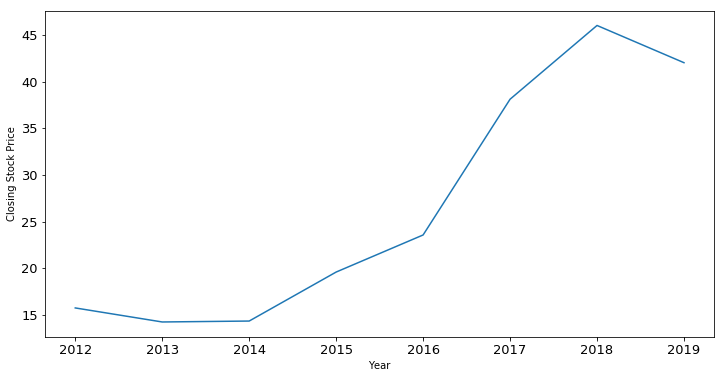

In [85]:
#Resampling
nintendo_yearly = NintendoDfClean.resample("Y").mean()
p = nintendo_yearly['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Year");

From our yearly graph we can see the effect that the Nintendo Switch release date had on the Nintendo stock value. However, we can also see that the stock has not recovered since that high, and they will need to improve on their E3 performance and online services to increase their stock values.

### Microsoft

#### Daily Frequencies

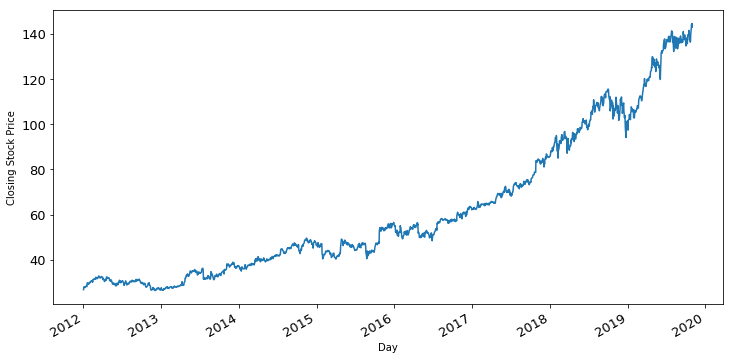

In [94]:
p = MicrosoftDfClean['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Day");

#### Monthly Frequencies

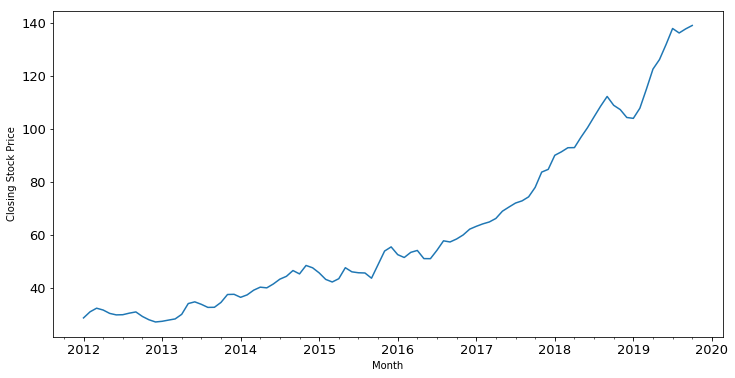

In [95]:
#Resampling
microsoft_monthly = MicrosoftDfClean.resample("M").mean()
p = microsoft_monthly['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Month");

We again see another drop in 2018, and then a sharp rise in the Microsoft stock. Lets use a graph splice to look into this more.

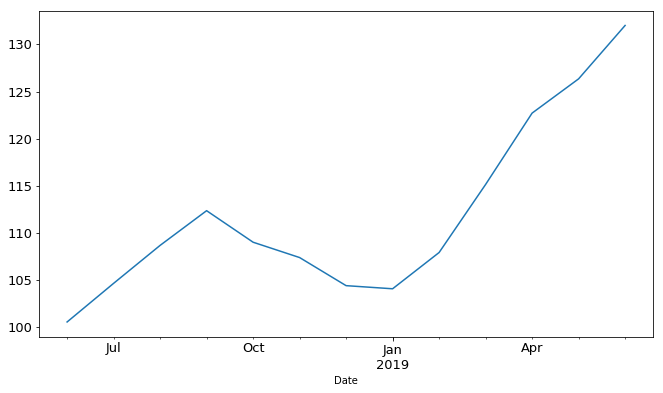

In [98]:
p = microsoft_monthly['Close']["2018-6":"2019-6"].plot(figsize=(11, 6), fontsize=13)

According to the Market Insider, Microsoft recorded modest quarterly earnings, however this was not enough to impress investors and shareholders as they were hoping to see more accelerated group (Chin 2018). 

After this drop however Microsoft stock price saw a massive 43.11% increase in 2019 (Chin 2018). This increase according to Investopedia is due to the rise in Cloud Computing (Chin 2018). Microsoft Cloud Computing Platform Azure won a government contract, which created a huge demand for the stock (Downey 2019). This again shows the important on cloud computing in the modern tech and gaming industry.

#### Quarterly Frequencies

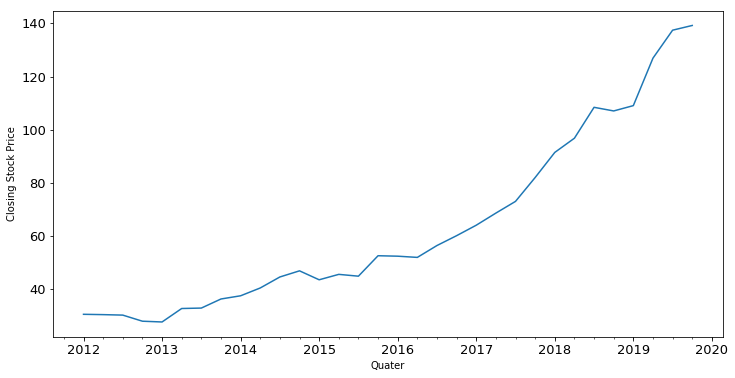

In [96]:
#Resampling
microsoft_quarterly = MicrosoftDfClean.resample("Q").mean()
p = microsoft_quarterly['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Quater");

#### Yearly Frequencies

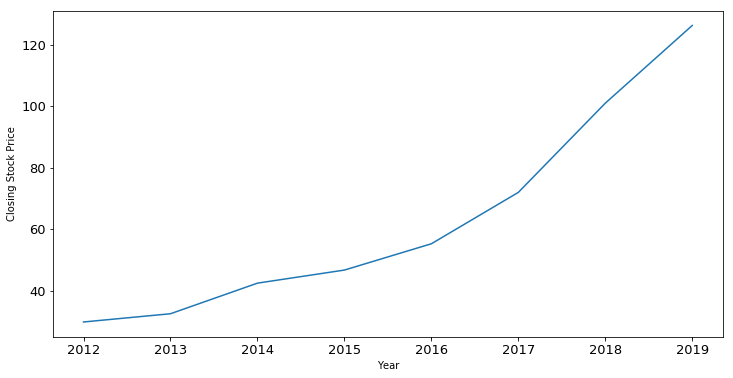

In [97]:
#Resampling
microsoft_yearly = MicrosoftDfClean.resample("Y").mean()
p = microsoft_yearly['Close'].plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Year");

From the quarterly and yearly graph, we can see that the drop in 2018 barely effected Microsoft stock price, and that it has had a steady increase in the years, with a now steepen increase from 2017 onwards.

## Comparing Stocks
To compare the stocks, I will first conact the closing values of each stock into one data frame, which will make it easier to visualise and compare the stock values. 

With this new combined stock data frame, I will again generate monthly, quarterly and annual frequencies data frames. From these I will be able to compare the performance of the stocks, and if there are any similar times in which they rise or fall. Also to show their relation I will be doing correlation testing to see if the price of one stock effects the others.

In [178]:
#Combine closing stock values
stocks = pd.concat([IntelDfClean["Close"], SonyDfClean["Close"], NintendoDfClean["Close"], MicrosoftDfClean["Close"]], axis =1)
stocks.columns = ['Intel', 'Sony', 'Nintendo', 'Microsoft']
#Write new dataframe to csv
stocks.to_csv('stocks.csv', sep=';')

#### Daily Frequencies

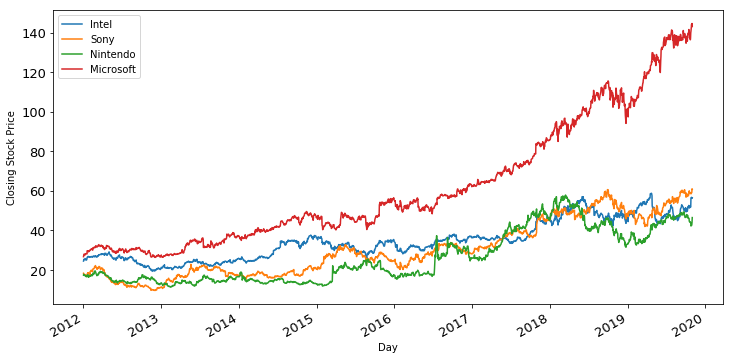

In [100]:
p = stocks.plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Day");

#### Monthly Frequencies

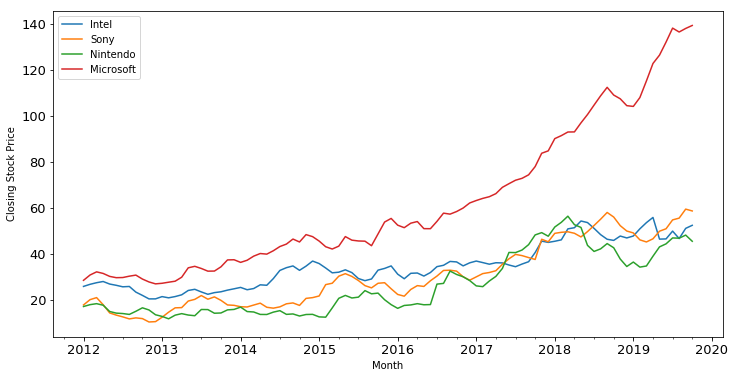

In [101]:
#Resampling
stocks_monthly = stocks.resample("M").mean()
p = stocks_monthly.plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Month");

From looking at the monthly graph, and from my previous individual analysis we saw that each of the stocks dropped during around 2017-2019. Along with the reasons I mentioned in my individual analysis, this could be due to the popping of the U.S stock Market, the bubble was created by the major tech companies from FANGMAN (Facebook, Amazon, Netflix, Google parent Alphabet, Microsoft, Apple and Nvidia). Due to these companies’ consistent growth, out performance and promise of new technologies, they were able to shrug off any disappointing performances (Mirhaydari 2018). This means that they were highly sought out from investors and increase the stock prices, which in turn inflated the bubble (Mirhaydari 2018). However as with all bubbles, they eventually pop. Which resulted in a drop of FANGMAN share value, but also had effected the whole stock market as they were such a dominating force (Mirhaydari 2018). From this we can see how interconnected the tech industry stocks are, also how much the tech industry has grown, and they have such a high share of the U.S Stock exchange.

#### Quarterly Frequencies

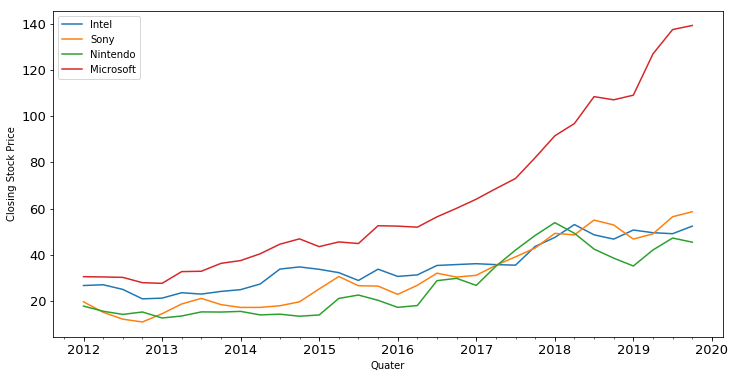

In [102]:
#Resampling
stocks_quarterly = stocks.resample("Q").mean()
p = stocks_quarterly.plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Quater");

#### Yearly Frequencies

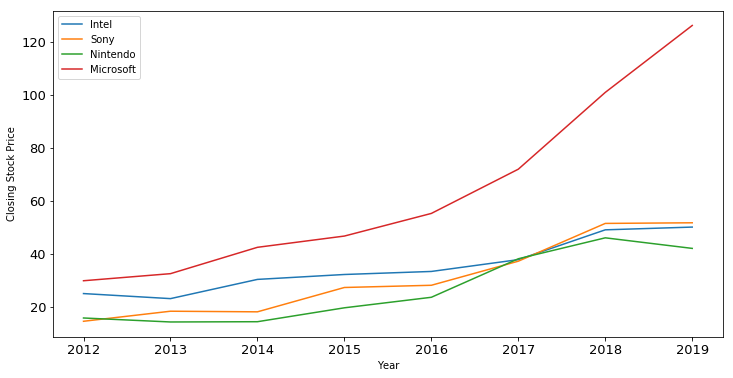

In [105]:
#Resampling
stocks_yearly = stocks.resample("Y").mean()
p = stocks_yearly.plot(figsize=(12, 6), fontsize=13)
plt.ylabel('Closing Stock Price')
plt.xlabel("Year");

From our yearly graph we can see that Microsoft has a much greater stock value.  It is clearly the leader of the console wars. However due to Microsoft also being a software development company, and that these stocks don’t purely represent the Xbox, Nintendo and PlayStation stock value. We cannot use these graphs to determine the winner of the console wars. However we can point out how dominating Microsoft is in the stock market.

The large difference of values has skewed our graph, which means that it looks like the Intel, Sony and Nintendo stock values are the same or close. To solve this, I will drop Microsoft from our dataset and see how close the other stock values truly are.

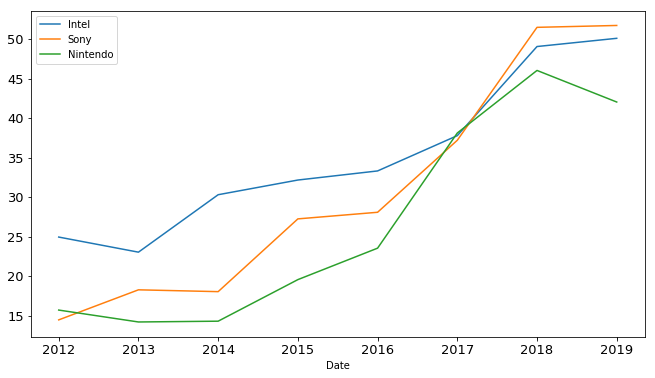

In [115]:
stock_yearly2 = stocks_yearly.drop(columns='Microsoft')

p = stock_yearly2.plot(figsize=(11, 6), fontsize=13)

From this we can see that the stocks Intel, Sony and Nintendo are very close in value, and that they were the same in 2017 year. However from these 2 graphs we see that as Microsoft is increasing the stock value, Intel and Sony are plateauing, while Nintendo is dropping. From this you could suggest that you should invest in Microsoft if you want a reliable steady increasing stock.

Microsoft success could be due to their innovation in cloud computing while the other companies have been lagging behind in their online cloud services. Intel is lack of innovation is also making their competitor AMD taking a greater market share, which too decreases their stock value.

### Correlation

I want to see if there is any correlation between the stocks. Which will show whether the stock have a possible relation to each other. To achieve this, I will use a scatter matrix which will visually show the correlation for each stock. To mathematically show the correlation I will use Pearson’s correlation to calculate the strength of the correlation.

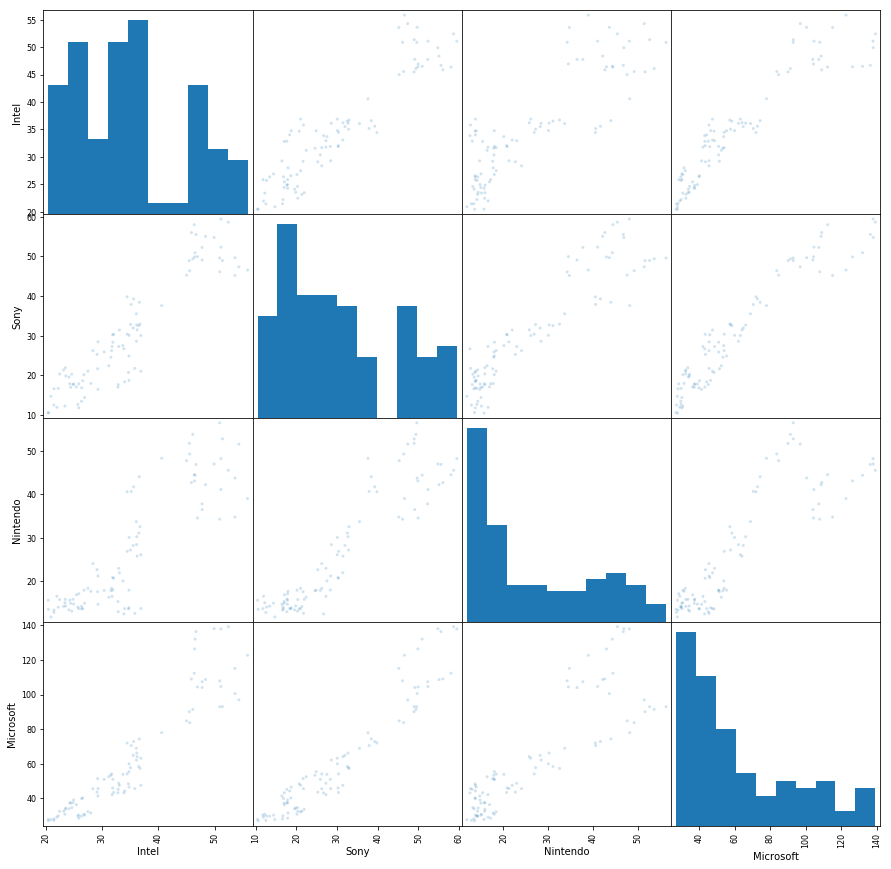

In [119]:
from pandas.plotting import scatter_matrix
#Large figsize to make the correlation easier to see.
scatter_matrix(stocks_monthly, alpha=0.2, figsize=(15, 15));

From this we can see that each stock has a positive correlation with each other. Which suggest that if one stock were to rise, the other will too. However, we cannot use this to correctly predict the stock prices, as they can be many other contributing factors. For example, as they are all tech companies, as the tech industry gets increasingly more popular, so would the rest of the tech companies.

In [177]:
from scipy.stats import pearsonr

#Intel's Pearson's correlation
corr_I_S, _ = (pearsonr(stocks_monthly['Intel'], stocks_monthly['Sony']))
corr_I_N, _ = (pearsonr(stocks_monthly['Intel'], stocks_monthly['Nintendo']))
corr_I_M, _ = (pearsonr(stocks_monthly['Intel'], stocks_monthly['Microsoft']))

#Sony's Pearson's correlation
corr_S_N, _ = (pearsonr(stocks_monthly['Sony'], stocks_monthly['Nintendo']))
corr_S_M, _ = (pearsonr(stocks_monthly['Sony'], stocks_monthly['Microsoft']))

#Nintendo Pearson's correlation
corr_N_M, _ = (pearsonr(stocks_monthly['Nintendo'], stocks_monthly['Microsoft']))


print("Intel and Sony Pearson's correlation: %.3f" % corr_I_S)
print("Intel and Nintendo Pearson's correlation: %.3f" % corr_I_N)
print("Intel and Microsoft Pearson's correlation: %.3f" % corr_I_M)
print("Sony and Nintendo Pearson's correlation: %.3f" % corr_S_N)
print("Sony and Microsoft Pearson's correlation: %.3f" % corr_S_M)
print("Nintendo and Microsoft Pearson's correlation: %.3f" % corr_N_M)


Intel and Sony Pearson's correlation: 0.924
Intel and Nintendo Pearson's correlation: 0.858
Intel and Microsoft Pearson's correlation: 0.932
Sony and Nintendo Pearson's correlation: 0.922
Sony and Microsoft Pearson's correlation: 0.953
Nintendo and Microsoft Pearson's correlation: 0.867


From using Pearson’s correlation, we can see that they all strong positive correlation. This reinforces the notion that the stocks are correlated, but again because there is a correlation this does not prove that there is a causation. But does prove there is a strong realtionship between the stocks. 

### Who won E3?
E3 is the largest gaming convention in which the major triple A game developers and console companies advertise their new games or systems. Each year there is always a debate in who 'won' E3 with the performance based on what each company presented in their conference. To calculate a possible change or effect of E3, I will compare the stock value changes within the month of E3. From this I can compare with the other stocks to see if any of them have 'won' E3. Since 2009, E3 is during June, which means I will compare the first and last week in June.

In [204]:
#Function to find the stock value change of June for each stock for inputted year
def e3Difference(year):
    results = []
    #Convert inputted year into June date
    date = year + "-05"
    #Resample to Weekly Frequency
    stocks_weekly = stocks.resample("W").mean()
    stockNames = ['Intel', 'Sony', 'Nintendo', 'Microsoft']
    #Have the year to be the first column.
    results.append(year)
    for stock in stockNames:
        #Compares the first row value for that stock, and the last row value for that stock.
        difference = stocks_weekly[date].tail(1)[stock].values[0] - stocks_weekly[date].head(1)[stock].values[0]
        results.append(difference)
    return results

years = ["2012", "2013","2014","2015","2016","2017","2018","2019"]
results = []
#Find the difference for each year
for year in years:
    results.append(e3Difference(year))    

e3 = pd.DataFrame(results, columns =['Date', 'Intel', 'Sony', 'Nintendo', 'Microsoft'])
e3 = e3.set_index('Date')
#Use idxmax to find the highest postive difference for each year, which will find the winner
e3['Winner'] = e3.idxmax(axis=1)
e3

,Intel,Sony,Nintendo,Microsoft,Winner
Date,,,,,
2012,-2.847999,-1.946000,-1.956000,-2.363999,Sony
2013,0.085000,5.013999,-0.098000,1.583001,Sony
2014,-0.328000,-1.474000,0.746000,-0.386000,Nintendo
2015,0.904999,0.409499,-0.402000,-1.582499,Intel
2016,-0.044001,2.527999,0.258001,0.720999,Sony
2017,-0.760000,1.345999,3.884000,-0.024002,Nintendo
2018,2.271000,0.254001,-3.690000,4.134000,Microsoft
2019,-6.959000,-0.780000,0.257999,-1.674999,Nintendo


From this data frame we can suggest the winner of E3 based of their stock value changes for that year during the e3 conference. However in 2012 all stocks reported a lost, which means you could suggest that 2012 had no winner. From this table you can see that there are changes in stock price, which suggest that E3 does affect the stock values. 

Currently there is no formal approach to who 'wins' E3, as it’s a matter of opinion and the impression each conference leaves on its investors. Therefore with this method of comparing stock price changes we could formulate a possible method to suggest who won E3. 

These conferences are the first impression of product, the feedback from this conference will greatly affect how the investor feels about the future of the company. At E3 each company is competing to win favour of the investors. This shows the importance of the conferences, advertainment, and how you portray yourself to investors.

## Conclusion
From my analysis of these stocks I have been able to see the consistent rise of the tech industy, specifcally the gaming industry. By looking at the different time frequencies we have been able to idenifity unique times for each stock in which they greatly dropped and falled. However from all of them we can see a rise of the industry from 2012-2019.

From analysing the drops in stock values we have seen that consisently the lack of innovation and developing new technoligues such as cloud computing will result in decrease of stock value, as you loss interest from investors. However if you have sucess in these future technoliges such as Microsoft Azure you will see a great increase of stock value. 

With our correlation analysis we can see that the 4 stocks are strongly correlated, which suggest that the gaming and technogloy industy is rising, and that each stocks have a strong relationship. We lastly tried to show the signifance of E3 on the stock prices. From this we saw for each year who won E3, and shows how investors reponse to E3 can affect the stock values.

To further my analysis of the gaming industry I would first need to calculate or gather the individual gaming company stock value instead of the parent company. For example, the stock price for Microsoft’s Xbox instead of using Microsoft.
As my stock values weren't specifically related to the game industry it's harder to distinguish the rise of the gaming industry and the possible leader. However my analysis has shown the growth and strength of the tech industry which each have a key interest and development into console and pc gaming.

## Bibliography
- Chin, Kimberly. “Microsoft Slides after Earnings Fail to Impress Wall Street (MSFT) | Markets Insider.” Business Insider, Business Insider, 1 Feb. 2018, https://markets.businessinsider.com/news/stocks/microsoft-stock-price-down-after-earnings-fail-to-impress-wall-street-2018-2-1014800738.
- Downey, Lucas. “Microsoft Shares Are Surging With Huge Demand.” Investopedia, Investopedia, 18 Nov. 2019, https://www.investopedia.com/microsoft-shares-are-surging-with-huge-demand-4775234.
- Mirhaydari, Anthony. “Why Tech Stocks Can Drag the Whole Market Down.” CBS News, CBS Interactive, 28 Mar. 2018, https://www.cbsnews.com/news/why-tech-stocks-can-drag-the-whole-market-down/.
- Noonan, Keith. “Why Sony Is Up 15% So Far in 2018.” The Motley Fool, The Motley Fool, 18 Nov. 2018, https://www.fool.com/investing/2018/11/18/why-sony-is-up-15-so-far-in-2018.aspx.
- Noonan, Keith. “Why Nintendo Is Down 15% in 2018 Year to Date.” The Motley Fool, The Motley Fool, 18 Nov. 2018, https://www.fool.com/investing/2018/11/18/why-nintendo-is-down-15-in-2018-year-to-date.aspx.
- Stevens, Pippa. “Intel Is Having Its Worst Week of 2019, and Two Experts See More Pain for the Dow Stock.” CNBC, CNBC, 10 May 2019, https://www.cnbc.com/2019/05/10/dow-stock-intel-is-having-its-worst-week-of-2019.html.